_ColormakerRegistry()

[utils.py:141 - _init_num_threads()] NumExpr defaulting to 8 threads.


molDWRow_1235
0.5


[tautomers.py:370 - _perform_tautomer_transformation()] Index of atom that moves: 23.
[tautomers.py:382 - _perform_tautomer_transformation()] Index of atom that donates hydrogen: 10
[tautomers.py:400 - _perform_tautomer_transformation()] Index of atom that accepts hydrogen: 8


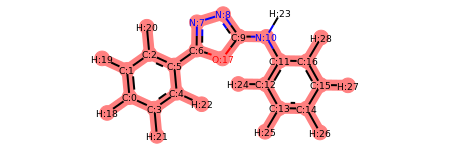

[tautomers.py:114 - add_droplet()] Adding droplet ...


Adding COM restraint to 30
Adding COM restraint to 33
Adding COM restraint to 36
Adding COM restraint to 39
Adding COM restraint to 42
Adding COM restraint to 45
Adding COM restraint to 48
Adding COM restraint to 51
Adding COM restraint to 54
Adding COM restraint to 57
Adding COM restraint to 60
Adding COM restraint to 63
Adding COM restraint to 66
Adding COM restraint to 69
Adding COM restraint to 72
Adding COM restraint to 75
Adding COM restraint to 78
Adding COM restraint to 81
Adding COM restraint to 84
Adding COM restraint to 87
Adding COM restraint to 90
Adding COM restraint to 93
Adding COM restraint to 96
Adding COM restraint to 99
Adding COM restraint to 102
Adding COM restraint to 105
Adding COM restraint to 108
Adding COM restraint to 111
Adding COM restraint to 114
Adding COM restraint to 117
Adding COM restraint to 120
Adding COM restraint to 123
Adding COM restraint to 126
Adding COM restraint to 129
Adding COM restraint to 132
Adding COM restraint to 135
Adding COM restr

[restraints.py:180 - __init__()] Center Of Mass restraint added.


0.5
Begin minimizing...


[ani.py:123 - minimize()] Minimization status: False


         Current function value: -17288808.428686
         Iterations: 936
         Function evaluations: 1121
         Gradient evaluations: 1109


In [1]:
from simtk import unit
import numpy as np
from tqdm import tqdm
import mdtraj as md
import nglview
from rdkit import Chem
from rdkit.Chem import AllChem
import neutromeratio
import matplotlib.pyplot as plt
import pickle
import torchani
import torch
import os
from neutromeratio.constants import device, platform

exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
#name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'

# name of the system
idx = 1880
# number of steps
n_steps = 50
# diameter
diameter_in_angstrom = 18
# where to write the results
base_path = '/tmp/'

mode = 'forward'

protocol = []
for name in exp_results:
    for lambda_value in np.linspace(0,1, 21):
        protocol.append((name, np.round(lambda_value, 2)))

name, lambda_value = protocol[idx-1]

print(name)
print(lambda_value)

t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit mol
tautomer = neutromeratio.Tautomer(name=name, intial_state_mol=neutromeratio.generate_rdkit_mol(t1_smiles), final_state_mol=neutromeratio.generate_rdkit_mol(t2_smiles), nr_of_conformations=20)
if mode == 'forward':
    tautomer.perform_tautomer_transformation_forward()
elif mode == 'reverse':
    tautomer.perform_tautomer_transformation_reverse()
else:
    raise RuntimeError('No tautomer reaction direction was specified.')

os.makedirs(f"{base_path}/{name}", exist_ok=True)
m = tautomer.add_droplet(tautomer.hybrid_topology, 
                            tautomer.hybrid_coords, 
                            diameter=diameter_in_angstrom * unit.angstrom, 
                             restrain_hydrogens=True,
                            file=f"{base_path}/{name}/{name}_lambda_{lambda_value:0.4f}_in_droplet_{mode}.pdb")

# define the alchemical atoms
alchemical_atoms=[tautomer.hybrid_hydrogen_idx_at_lambda_1, tautomer.hydrogen_idx]

print('Nr of atoms: {}'.format(len(tautomer.ligand_in_water_atoms)))


# extract hydrogen donor idx and hydrogen idx for from_mol
model = neutromeratio.ani.LinearAlchemicalDualTopologyANI(alchemical_atoms=alchemical_atoms)
model = model.to(device)
torch.set_num_threads(2)

# perform initial sampling
energy_function = neutromeratio.ANI1_force_and_energy(
                                        model = model,
                                        atoms = tautomer.ligand_in_water_atoms,
                                        mol = None,
                                        )

tautomer.add_COM_for_hybrid_ligand(np.array([diameter_in_angstrom/2, diameter_in_angstrom/2, diameter_in_angstrom/2]) * unit.angstrom)

for r in tautomer.ligand_restraints:
    energy_function.add_restraint(r)

for r in tautomer.hybrid_ligand_restraints:
    energy_function.add_restraint(r)

for r in tautomer.solvent_restraints:
    energy_function.add_restraint(r)

for r in tautomer.com_restraints:
    energy_function.add_restraint(r)

print(lambda_value)
energy_and_force = lambda x : energy_function.calculate_force(x, lambda_value)
langevin = neutromeratio.LangevinDynamics(atoms = tautomer.ligand_in_water_atoms,                            
                            energy_and_force = energy_and_force)

x0 = tautomer.ligand_in_water_coordinates
x0, e_history = energy_function.minimize(x0, lambda_value=1.0) 

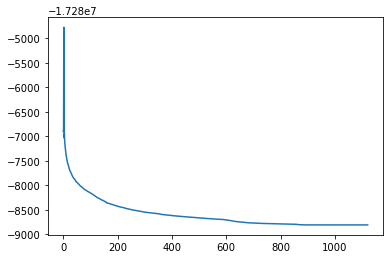

In [3]:
plt.plot([e.value_in_unit(unit.kilojoule_per_mole) for e in e_history])
plt.xlabel = 'test'
plt.ylabel = 'test'
plt.show()

In [8]:
raw_energies = np.array([e.value_in_unit(unit.kilojoule_per_mole) for e in e_history])

In [9]:

e_min = raw_energies[0]
running_minimum_energies = [e_min]
for i in range(1, len(raw_energies)):
    e_min = min(e_min, raw_energies[i])
    running_minimum_energies.append(e_min)
running_minimum_energies = np.array(running_minimum_energies)

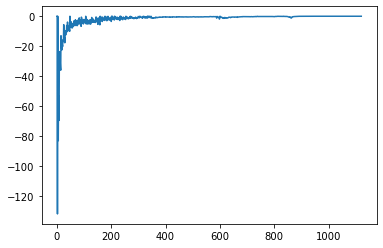

In [10]:
plt.plot(np.diff(running_minimum_energies))
plt.xlabel = 'test'
plt.ylabel = 'test'
plt.show()

In [ ]:
# TODO: double-check that energy output here is in float64 rather than float32

In [5]:
np.diff?

In [ ]:
traj_in_nm = [x.value_in_unit(unit.nanometer) for x in x0]
import nglview
ani_traj = md.Trajectory(traj_in_nm, tautomer.ligand_in_water_topology)
v = neutromeratio.vis.generate_nglview_object(ani_traj)
v.add_representation(repr_type='ball+stick', selection='water', opacity=0.4, color='blue')
v.shape.add_sphere([diameter_in_angstrom/2, diameter_in_angstrom/2, diameter_in_angstrom/2], [0,0,1], (diameter_in_angstrom-2)/2)
v.update_representation(component=1, repr_index=0, opacity=0.2)
v

In [ ]:
exit
stop

In [ ]:
ani_traj.save_dcd('water_looses_hydrogen.dcd')
ani_traj.save_dcd('water_looses_hydrogen.pdb')

In [ ]:
traj_in_nm = [x.value_in_unit(unit.nanometer) for x in equilibrium_samples]
import nglview
#ani_traj = md.Trajectory(traj_in_nm[::20], tautomer.ligand_in_water_topology)
v = neutromeratio.vis.generate_nglview_object(ani_traj)
v.add_representation(repr_type='ball+stick', selection='water', opacity=0.4, color='blue')
v.shape.add_sphere([diameter_in_angstrom/2, diameter_in_angstrom/2, diameter_in_angstrom/2], [0,0,1], diameter_in_angstrom/2-1)
v.update_representation(component=1, repr_index=0, opacity=0.2)
v

In [ ]:
energy = [x.value_in_unit(unit.kilocalorie_per_mole) for x in energies]
plt.plot(energy)

In [ ]:
a = np.array([1.,2.,4.]) * unit.angstrom

In [ ]:
a.value_in_unit(unit.angstrom)